# **CISC3024 Pattern Recognition Final Project**
## Group Members:
- Huang Yanzhen, DC126732
- Mai Jiajun, DC127853

# 0. Project Setup

## 0.1 Packages & Device

In [107]:
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from tqdm import tqdm

# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
import scipy.io as sio

# Visualize Result
from sklearn.metrics import (confusion_matrix, accuracy_score,
                            precision_score, recall_score,
                            f1_score, roc_auc_score,
                            roc_curve, auc, precision_recall_curve,
                            average_precision_score)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

# Basic
import numpy as np
import cv2
import os
import time
from typing import List, Tuple, Union
import random
import itertools

In [108]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
print(f"Using device: {device_name}")

Using device: cuda


## 0.2 Global Configurations

In [109]:
path_dataset = "./data/SVHN_mat"

# 1. Data Processing and Augmentation

## 1.1 Download Datasets
Define dataset class, retrieve dataset.

### 1.1 Notes

In [ ]:
_dat = sio.loadmat(os.path.join(path_dataset, "train_32x32.mat"))
# _dat['X'][0][0][0]
# np.array(_dat).shape
dat = np.transpose(_dat['X'], (3, 0, 1, 2))
# dat = dat.astype(np.float32)
dat.shape

In [ ]:
# First Image
dat[0].shape

In [ ]:
# First Row of Image
dat[0][0]

In [ ]:
# First Pixel of Image
dat[0][0][0]

In [ ]:
_transform = A.Compose([
    A.Normalize(mean=[0.4376845359802246, 0.4437684714794159, 0.47280389070510864], std=[0.19803018867969513, 0.2010156661272049, 0.19703581929206848]),
    ToTensorV2()
])

_img = dat[0]
_img = _transform(image=_img)['image']
# print(_img)
_img.shape

### 1.2 Dataset

In [110]:
class SVHNDataset(Dataset):
    def __init__(self, mat_file, transform=None, indecies=None):
        data = sio.loadmat(mat_file)
        
        self.source_file_path = mat_file  # For re-construction.
        self.images = np.transpose(data['X'], (3, 0, 1, 2))
        self.labels = data['y'].flatten()
        self.labels[self.labels == 10] = 0
        self.transform = transform        # Allow postponed injection of transform.

        if indecies is not None:          # For re-construction. Only keep data with wanted indecies.
            self.images = self.images[indecies]
            self.labels = self.labels[indecies]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # There should always be a transform. 
        # It converts image to float, and permutes it from (32, 32, 3) to Tensor([3, 32, 32]).
        # ...which is important!!
        if self.transform is None:        
            raise ValueError("CISC3024 Custom Error: The transform should not be None when this object is passed into a DataLoader.")

        image = self.transform(image=image)['image']
        return image, label

    def get_meanstd(self):
        images_ = self.images.astype(np.float32) / 255.0
        mean = np.mean(images_, axis=(0,1,2))
        std = np.std(images_, axis=(0,1,2), ddof=0)
        
        return mean.tolist(), std.tolist()

## 1.2 Peak A Data

In [111]:
def peek(dataset):
    def unnormalize(img, mean, std):
        """Revert the normalization for visualization."""
        img = img * std + mean
        return np.clip(img, 0, 1)

    # Plotting multiple images in a grid
    grid_rows, grid_cols = 1, 6
    
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(6, 6))
    
    peek_index = random.randint(0, dataset.__len__()-1)
    
    for i in range(grid_cols):
        img_tensor, label = dataset.__getitem__(peek_index)
        img = img_tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
        img = unnormalize(img, norm_mean, norm_std)
    
        ax = axes[i]  # Get subplot axis
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
    
    plt.tight_layout()
    plt.show()
    print(f"Peaking data from training set of index {peak_index}.\nImage Tnesor Size:{train_dataset.__getitem__(peak_index)[0].shape}")

# 2. Neural Network

## 2.1 Model Structure

In [112]:
class SmallVGG(nn.Module):
    def __init__(self, frame_size=32):
        super(SmallVGG, self).__init__()
        self.frame_size = frame_size
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8x8

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4x4
        )
    
        self.fc_layers = nn.Sequential(
            nn.Linear(frame_size * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## 2.2 Train and Evaluate Function

In [113]:
def train_and_evaluate(model,
                      train_loader,
                      valid_loader,
                      criterion,
                      optimizer,
                      num_epochs=100):
    # Record Losses to plot
    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        # Train
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(images)
        train_losses.append(running_loss / len(train_loader))

        # Evaluate
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * len(images)

        valid_losses.append(valid_loss / len(valid_loader))
        print(f"Epoch[{epoch+1}/{num_epochs}], Train Loss:{train_losses[-1]:.4f}, Validation Loss:{valid_losses[-1]:.4f}")

    return train_losses, valid_losses

## 2.3 Get Predictions
Multiple functions are defined to evaluate data. Below is a list of them.

In [126]:
def get_predictions(model_path, extra_loader):
    if not isinstance(model_path, str):
        model_state = model_path
    else:
        model_state = torch.load(model_path)
    model = SmallVGG()
    model.load_state_dict(model_state)
    
    model.to(device)
    model.eval() 
    
    pred_scores = []  # Prob. of predictions
    true_labels = []  # Ground Truth
    pred_labels = []  # Label of prediction, i.e., argmax(softmax(pred_scores))
    
    with torch.no_grad():
        for images, labels in tqdm(extra_loader):
            images, labels = images.to(device), labels.to(device)
        
            outputs = model(images)
    
            pred_scores_batch = nn.functional.softmax(outputs, dim=-1)
    
            pred_scores.extend(pred_scores_batch.cpu().tolist())
            pred_labels.extend(outputs.argmax(dim=1).tolist())
            true_labels.extend(labels.cpu().tolist())
            
    return pred_scores, true_labels, pred_labels

## 2.4 Get Metrics

In [127]:
def get_metrics(true_labels, pred_labels):
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, zero_division=1, average=None, labels=range(0,10))
    recall = recall_score(true_labels, pred_labels, zero_division=1, average=None, labels=range(0,10))
    f1 = f1_score(true_labels, pred_labels, zero_division=0, average=None, labels=range(0,10))

    return accuracy, precision, recall, f1

In [128]:
def print_metrics(accuracies, f1s):
    print(f"Accuracies:")
    for acc in accuracies:
        print(f"{acc:.3f}", end=" ")
    print("\n")
    
    print(f"F1 Score Lists:")
    mean_f1s = []
    for f1 in f1s:
        for val in f1:
            print(f"{val:.3f}", end=" ")
        mean_f1 = np.mean(f1)
        std_f1 = np.std(f1)
        mean_f1s.append(mean_f1)
        print(f"| Avg F1={mean_f1:.3f}, Std F1={std_f1}")
    print(f"Best: {np.argmax(mean_f1s)+1}-th")

In [129]:
# Compute ROC AUC for each class
def get_roc_auc(true_labels_bin, pred_labels_bin):
    roc_auc = dict()
    for i in range(0, 10):
        roc_auc[i] = roc_auc_score(true_labels_bin[:,i], np.array(pred_scores)[:, i])
    return roc_auc

# 3. Experiments

## 3.0 Preparation

### 3.0.1 Plot Functions

The experiments will be a list of the following structures:
```python
{
    "HYPER_PARAM_1": combo[0],
    "HYPER_PARAM_2": combo[1],
    "train_losses": train_losses,
    "valid_losses": valid_losses,
    "model_state_dict": exp_model.state_dict()
}
```

#### Epoch-Loss Curves

In [130]:
def plot_el(loaded_experiments, hyper_param_names, n_rows=4, n_cols=4):
    fig_size = (n_cols * 5, n_rows * 5)
    n1, n2 = hyper_param_names
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=fig_size)
    # plt.tight_layout()
    
    for i, ax in enumerate(axes.flat):
        train_losses, valid_losses = loaded_experiments[i]["train_losses"], loaded_experiments[i]["valid_losses"]
        
        ax.plot(train_losses, label=f"TRL, min={np.min(train_losses):.3f}")
        ax.plot(valid_losses, label=f"VAL, min={np.min(valid_losses):.3f} at step={np.argmin(valid_losses)}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.set_title(f"{n1}={loaded_experiments[i][n1]}, {n2}={loaded_experiments[i][n2]}")
        ax.legend(loc="upper right")
    
    plt.show()

#### Get Experiment Results

In [131]:
def get_experiment_results(loaded_experiments, test_hyperparam_names, extra_loader):
    experiment_results = []
    n1, n2 = test_hyperparam_names
    for i, exp in enumerate(loaded_experiments):
        pred_scores, true_labels, pred_labels = get_predictions(exp['model_state_dict'], extra_loader)
        experiment_results.append({
            n1: exp[n1],
            n2: exp[n2],
            "true_labels": true_labels,
            "pred_labels": pred_labels,
            "pred_scores": pred_scores
        })

        print(f"First 10 true labels:")
        [print(num, end=" ") for num in true_labels[:10]]
        print(f"...\n")

        print(f"First 10 pred labels:")
        [print(num, end=" ") for num in pred_labels[:10]]
        print(f"...\n")

        print(f"First 5 pred_scores:")
        [print(num, end=" ") for num in pred_scores[:5]]
        print(f"...\n")

        # del pred_scores, true_labels, pred_lables
        torch.cuda.empty_cache()
    return experiment_results

#### Confusion Matrix

In [132]:
def plot_cm(experiment_results, hyper_param_names, n_rows=4, n_cols=4):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten()

    hparam_1, hparam_2 = hyper_param_names
    
    for i, exp_rs in enumerate(experiment_results):
        true_labels, pred_labels = exp_rs['true_labels'], exp_rs['pred_labels']
        cm = confusion_matrix(true_labels, pred_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(0,10))
        disp.plot(ax=axes[i], cmap = plt.cm.Blues)
        axes[i].set_title(f"Exp {i+1}: {hparam_1}={exp_rs[hparam_1]}, {hparam_2}={exp_rs[hparam_2]}")
    
    plt.tight_layout()
    plt.show()

#### Precision-Recall Curve

In [133]:
def plot_pr(experiment_results, hyper_param_names, n_rows=4, n_cols=4):
    fig, axes = plt.subplots(n_rows,n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten()

    hparam_1, hparam_2 = hyper_param_names
    accuracies = []
    f1_scores = []
    
    for i, exp_rs in enumerate(experiment_results):
        true_labels, pred_labels, pred_scores = exp_rs['true_labels'], exp_rs['pred_labels'], exp_rs['pred_scores']
        true_labels_bin, pred_labels_bin = label_binarize(true_labels, classes=range(0,10)), label_binarize(pred_labels, classes=range(0,10))
        
        accuracy, precision, recall, f1 = get_metrics(true_labels, pred_labels)
        accuracies.append(accuracy)
        f1_scores.append(f1)
        
        for j in range(0, 10):
            # print(f"Class {j}: Prec:{precision[j]:.2f}, Recall:{recall[j]:.2f}, F_1 Score:{f1[j]:.2f}")
            precision_i, recall_i, _ = precision_recall_curve(true_labels_bin[:, j], np.array(pred_scores)[:, j])
    
            average_precision = average_precision_score(true_labels_bin[:, j], np.array(pred_scores)[:, j])
            axes[i].step(recall_i, precision_i, where="post", label=f"Class {j} AP={average_precision:.2f}")
            axes[i].set_title(f"PR-Curve {hparam_1}={exp_rs[hparam_1]}, {hparam_2}={exp_rs[hparam_2]}")
        axes[i].legend()
        axes[i].set_xlabel("Recall")
        axes[i].set_ylabel("Precision")
    
    # for j in range(i+1, 16):
    #     fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    return accuracies, f1_scores

#### ROC-AUC Curve

In [134]:
def plot_rocauc(experiment_results, hyper_param_names, curve_type, n_rows=4, n_cols=4):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten()

    hparam_1, hparam_2 = hyper_param_names

    for i, exp_rs in enumerate(experiment_results):
        true_labels, pred_scores = exp_rs['true_labels'], exp_rs['pred_scores']
        true_labels_bin = label_binarize(true_labels, classes=range(0, 10))

        # All Classes' ROC curve & ROC Area Under Curve
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for j in range(10):
            fpr[j], tpr[j], _ = roc_curve(true_labels_bin[:, j], np.array(pred_scores)[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])

        # Macro-Average ROC & ROC-AUC
        all_fpr = np.unique(np.concatenate([fpr[j] for j in range(10)]))
        mean_tpr = np.zeros_like(all_fpr)
        for j in range(10):
            mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
        mean_tpr /= 10

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_bin.ravel(), np.array(pred_scores).ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Plot only Macro or Micro ROC curves
        if curve_type == "macro_micro":
            axes[i].plot(fpr["macro"], tpr["macro"], label=f"Macro (AUC={roc_auc['macro']:.2f})")
            axes[i].plot(fpr["micro"], tpr["micro"], label=f"Micro (AUC={roc_auc['micro']:.2f})")
        elif curve_type == "all":
            # Plot all ROC curves
            for j in range(10):
                axes[i].plot(fpr[j], tpr[j], label=f"Class {j} (AUC={roc_auc[j]:.2f})")

        axes[i].plot([0, 1], [0, 1], "k--")
        axes[i].set_xlabel("False Positive Rate")
        axes[i].set_ylabel("True Positive Rate")
        axes[i].set_title(f"ROC Curve {i+1}, {hparam_1}={exp_rs[hparam_1]}, {hparam_2}={exp_rs[hparam_2]}")
        axes[i].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

### 3.0.1 Datasets

In [135]:
def split_train_valid(train_dataset, train_ratio):
    ori_len = len(train_dataset)
    train_size = int(train_ratio * ori_len)
    valid_size = ori_len - train_size

    # These are subsets!! Don't directly use them or you will spend 2 hours solving for it.
    train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

    # Re-construct two SVHNDataset object from indecies
    train_dataset_ = SVHNDataset(mat_file=train_dataset.source_file_path, 
                                 transform=train_dataset.transform, 
                                 indecies=train_subset.indices)

    valid_dataset_ = SVHNDataset(mat_file=train_dataset.source_file_path, 
                                 transform=train_dataset.transform, 
                                 indecies=valid_subset.indices)
    
    return train_dataset_, valid_dataset_

## 3.1 Experiment 1: Optimizer
In the standard process of gradient descent, each update is proportional to the negative gradient (first-order derivative) of the loss function with respect to the parameter. In this traditional process, the learning rate is fixed, and it may cause problems.
- Oscillations. If locally, the learning rate is too high, the model will jump around the local minimum.
- Slow convergence. If locally, the learning rate is too low, the model will spend a lot of epochs to converge to a local minimum.

To solve this problem, we enable the learning rate to be adaptive by introducing the "momentum", a velocity-like term which accumulates past gradients in the direction of consistent descent.
- The velocity term is the weighted sum of previous gradients.
- ...such that the update direction does not only rely on the current gradient, but also on previous ones.

The update of velocity is represnted as:
$$
v_t=\beta v_{t-1} + (1-\beta)\cdot\nabla J(\theta)
$$
where $\beta$ is the momentum coefficient. In our experiments, $\beta$ will be fixed to $0.9$.

The update of parameters will be:
$$
\theta_{t} = \theta_{t-1}-\eta\cdot v_{t}
$$
In this experiment, we focus on the performance of different optimizers, each has its own optimized way to update the momentum. We will fix other variables, including transform, epoch number and learning rate, and only adjust the optimizers. There are a few optimizers to be chozen:

- Adaptive Moment Estimation (Adam)
- Stochastic Gradient Descent (SGD)
- Root Mean Square Propagation (RMSprop)
- Adam with Weight Decay (AdamW)
- Adaptive Gradient Algorithm (Adgrad)
- SGD with Momentum and Nesterove Accelerated Gradient

In [136]:
# Universal Train Dataset without splitting
exp1_universal_train_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"train_32x32.mat"))
exp1_mean, exp1_std = exp1_universal_train_dataset.get_meanstd()

print(f"Channel Means: {exp1_mean}")
print(f"Channel Stds: {exp1_std}")

Channel Means: [0.4376845359802246, 0.4437684714794159, 0.47280389070510864]
Channel Stds: [0.19803018867969513, 0.2010156661272049, 0.19703581929206848]


Define changing & non-changing hyper parameters.

In [137]:
exp1_hyperparams = {
    "num_epochs": 30,
    "lr": 1e-5,
    "criterion": nn.CrossEntropyLoss(),
    "transform": A.Compose([
        A.Normalize(mean=exp1_mean, std=exp1_std),
        ToTensorV2()
    ])
}

exp1_models = [SmallVGG().to(device) for _ in range(0,6)]

candidate_optimizers = [
    optim.Adam(exp1_models[0].parameters(), lr=exp1_hyperparams['lr']), 
    optim.SGD(exp1_models[1].parameters(), lr=exp1_hyperparams['lr'], momentum=0.9),
    optim.RMSprop(exp1_models[2].parameters(), lr=exp1_hyperparams['lr']),
    optim.AdamW(exp1_models[3].parameters(), lr=exp1_hyperparams['lr'], weight_decay=0.01),
    optim.Adagrad(exp1_models[4].parameters(), lr=exp1_hyperparams['lr']),
    optim.SGD(exp1_models[5].parameters(), lr=exp1_hyperparams['lr'], momentum=0.9, nesterov=True)]

Train, Validation and Test datasets.

In [138]:
# Train & Test Dataset
exp1_train_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"train_32x32.mat"), transform=exp1_hyperparams['transform'])
exp1_train_dataset, exp1_valid_dataset = split_train_valid(exp1_train_dataset, train_ratio=0.8)

# Test Dataset
exp1_test_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"test_32x32.mat"), transform=exp1_hyperparams['transform'])

print(f"Train Size:{exp1_train_dataset.__len__()}\nValidation Size:{exp1_valid_dataset.__len__()}\nTest Size:{exp1_test_dataset.__len__()}")

Train Size:58605
Validation Size:14652
Test Size:26032


Train, Validation and Test Data Loaders.

In [139]:
# Data Loaders
exp1_train_loader = DataLoader(exp1_train_dataset, batch_size=128, shuffle=True)
exp1_valid_loader = DataLoader(exp1_valid_dataset, batch_size=128, shuffle=True)
exp1_test_loader = DataLoader(exp1_test_dataset, batch_size=128, shuffle=False)

**Run Experiments**

In [140]:
def run_exp1(optimizers, models, hyper_params, train_loader, valid_loader):
    experiments = []
    for i, [optimizer, exp1_model] in enumerate(zip(optimizers, models)):
        print(f"Experiment {i+1}. Running experiment on optimizer: {optimizer.__class__.__name__}")

        criterion = hyper_params['criterion']
        num_epochs = hyper_params['num_epochs']
        train_losses, valid_losses = train_and_evaluate(exp1_model, train_loader, valid_loader, criterion, optimizer, num_epochs)

        experiments.append({
            "optimizer": optimizer.__class__.__name__,
            "others":"same",
            "train_losses": train_losses,
            "valid_losses": valid_losses,
            "model_state_dict": exp1_model.state_dict()
        })

        del exp1_model, criterion, optimizer
        torch.cuda.empty_cache()

    return experiments

In [ ]:
exp1 = run_exp1(candidate_optimizers, exp1_models, exp1_hyperparams, exp1_train_loader, exp1_valid_loader)
time_str = str(time.time()).replace(".","")
torch.save(exp1, f"./models/exp1_{time_str}.pth")

**Load Experiments**

Load Experiment objects and plot results.

In [ ]:
exp1_loaded = torch.load("./models/exp1_17303103076259832.pth")
exp1_results = get_experiment_results(exp1_loaded, test_hyperparam_names=["optimizer", "others"], extra_loader=exp1_test_loader)

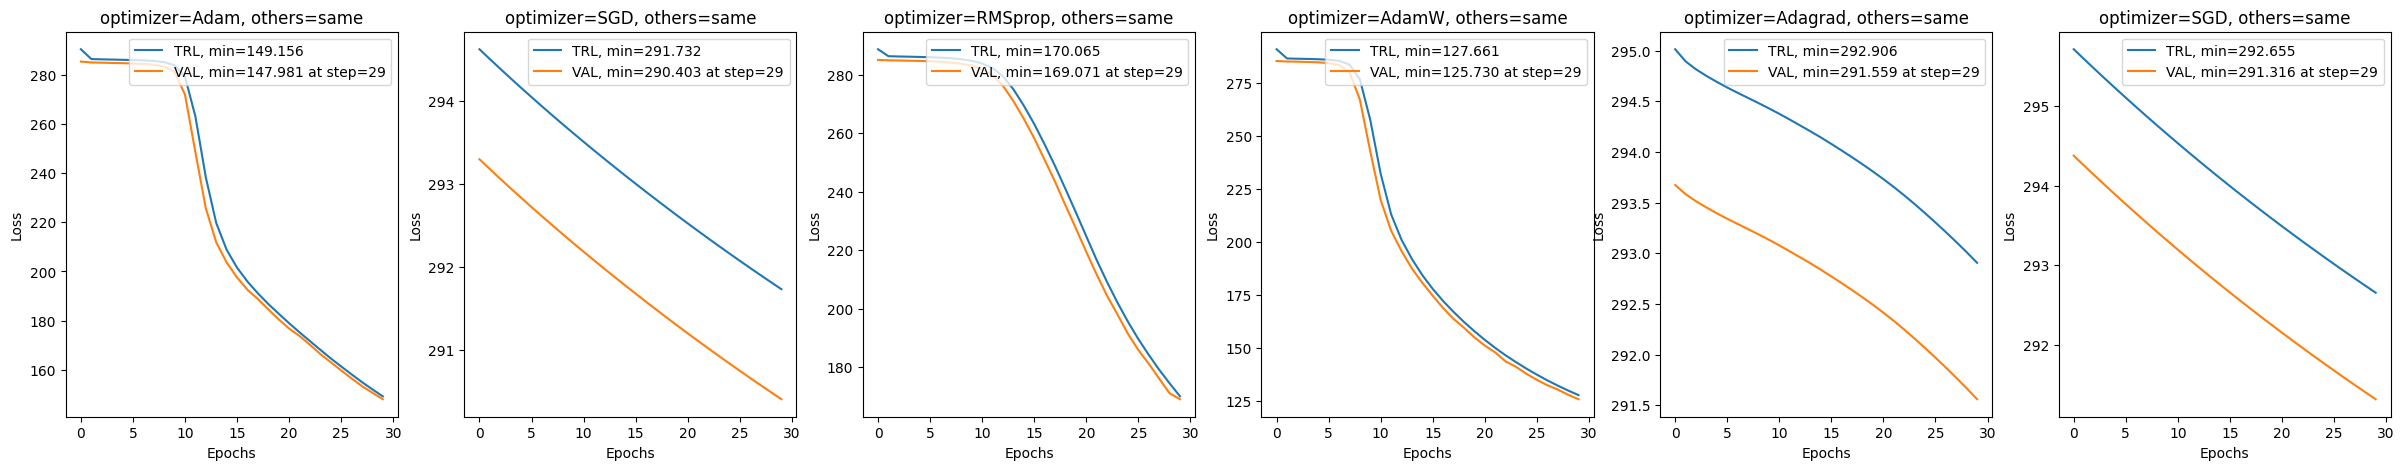

In [143]:
plot_el(exp1_loaded, ["optimizer", "others"], n_rows=1, n_cols=6)

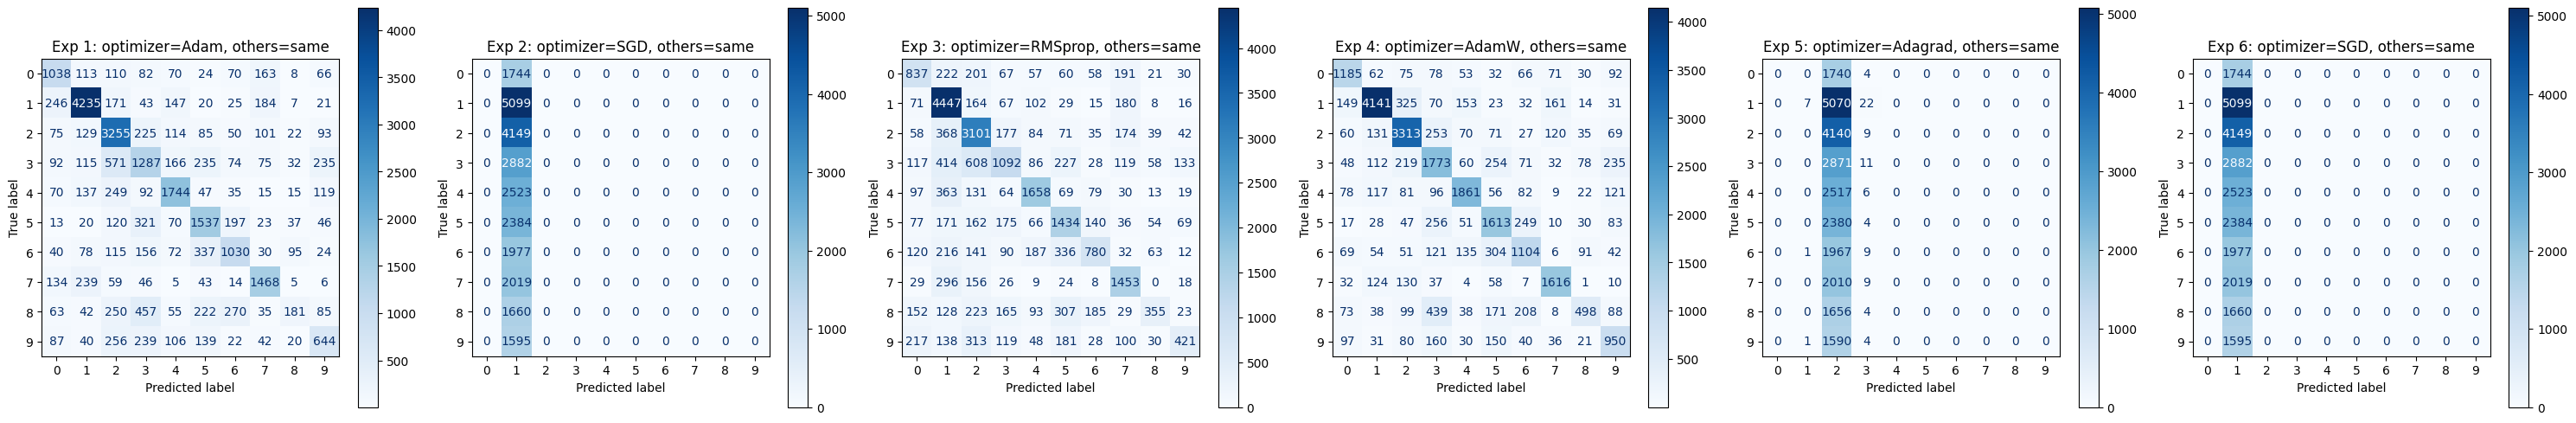

In [144]:
plot_cm(exp1_results, ["optimizer", "others"], n_rows=1, n_cols=6)

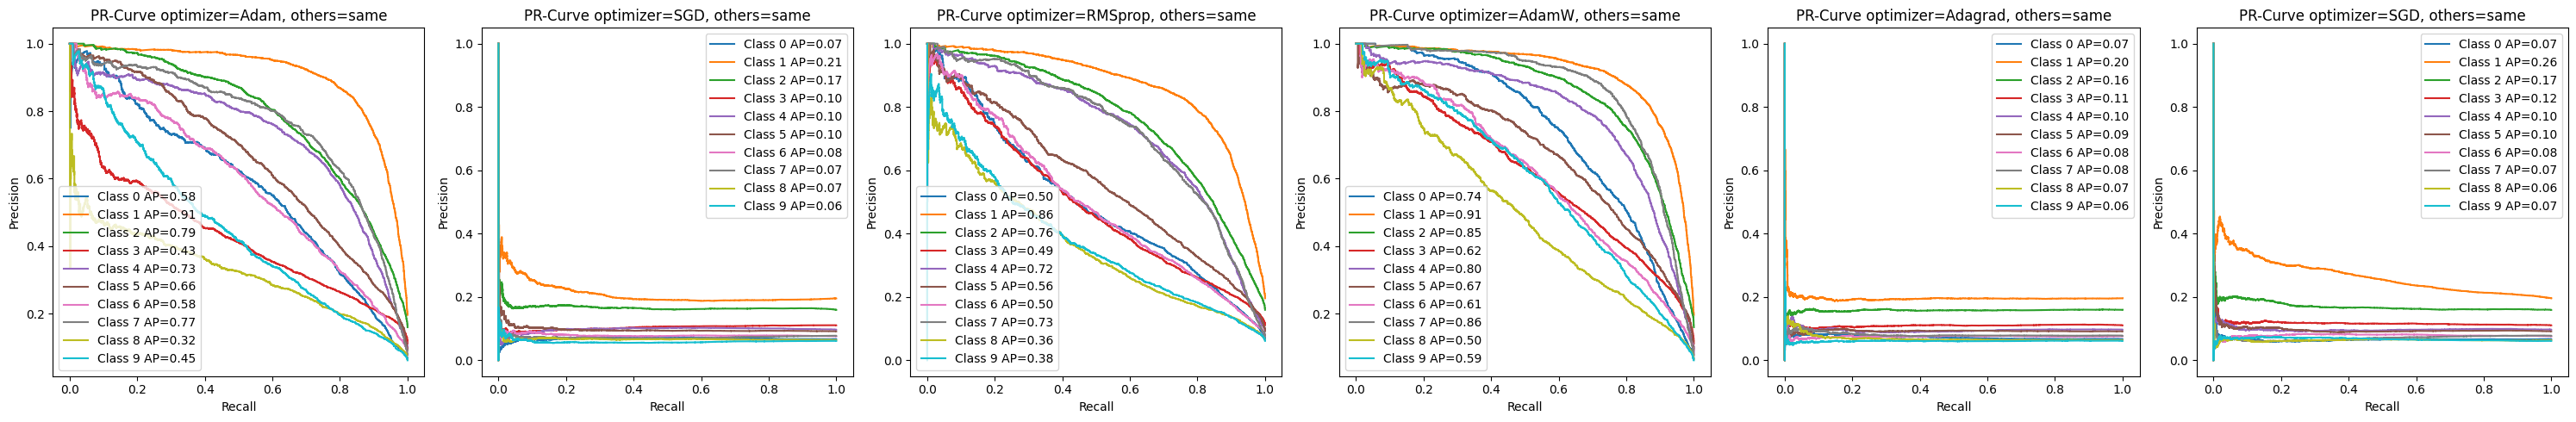

Accuracies:
0.631 0.196 0.598 0.694 0.160 0.196 

F1 Score Lists:
0.576 0.827 0.700 0.442 0.688 0.606 0.547 0.707 0.174 0.439 | Avg F1=0.570, Std F1=0.1753831142304276
0.000 0.328 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 | Avg F1=0.033, Std F1=0.09827503131926378
0.476 0.750 0.663 0.444 0.675 0.560 0.468 0.666 0.309 0.354 | Avg F1=0.536, Std F1=0.1415449491104527
0.667 0.833 0.773 0.575 0.748 0.631 0.572 0.791 0.402 0.573 | Avg F1=0.656, Std F1=0.12561763454635042
0.000 0.003 0.275 0.007 0.000 0.000 0.000 0.000 0.000 0.000 | Avg F1=0.029, Std F1=0.08224465792289748
0.000 0.328 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 | Avg F1=0.033, Std F1=0.09827503131926378
Best: 4-th


In [145]:
exp1_accuracies, exp1_f1s = plot_pr(exp1_results, ["optimizer", "others"], n_rows=1, n_cols=6)
print_metrics(exp1_accuracies, exp1_f1s)

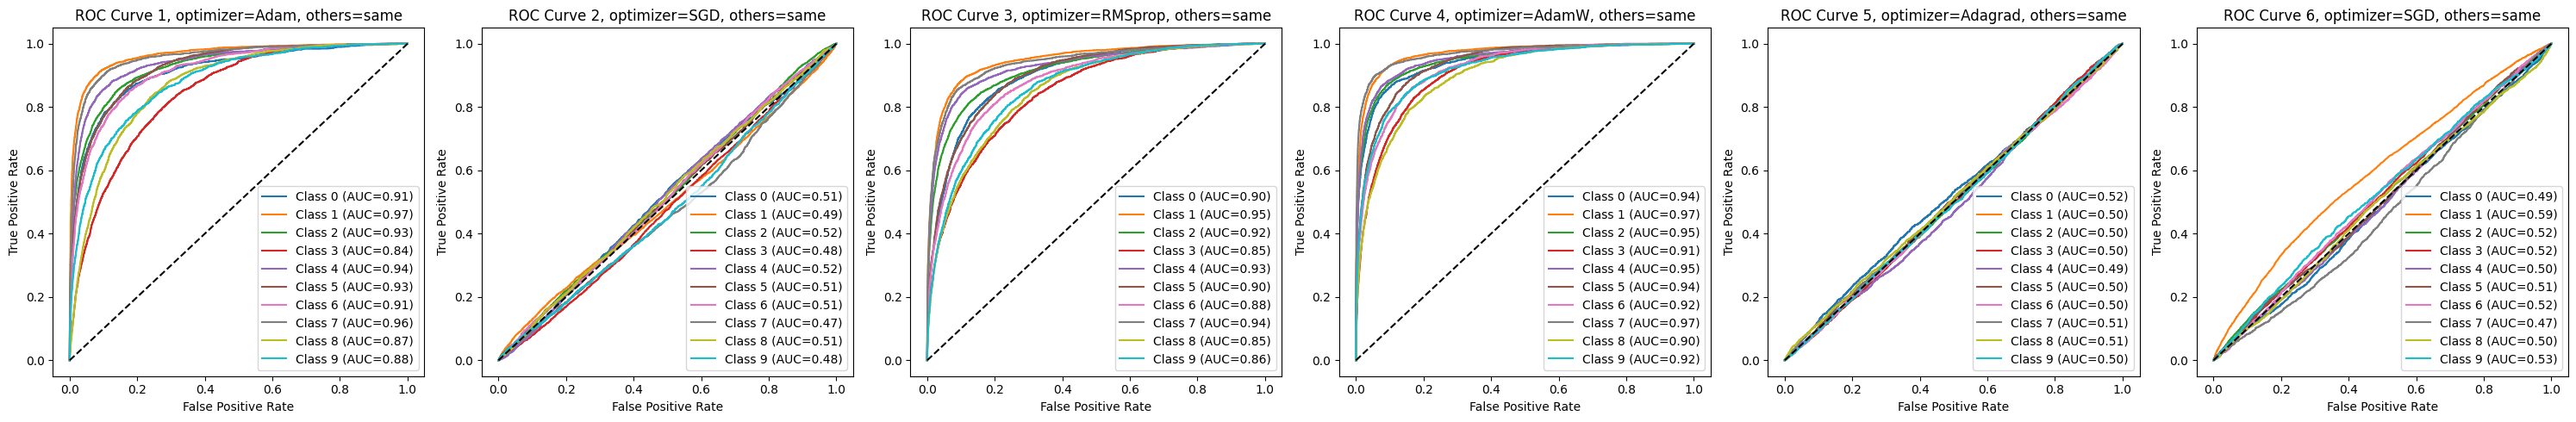

In [146]:
plot_rocauc(exp1_results, ["optimizer", "others"], curve_type="all", n_rows=1, n_cols=6)

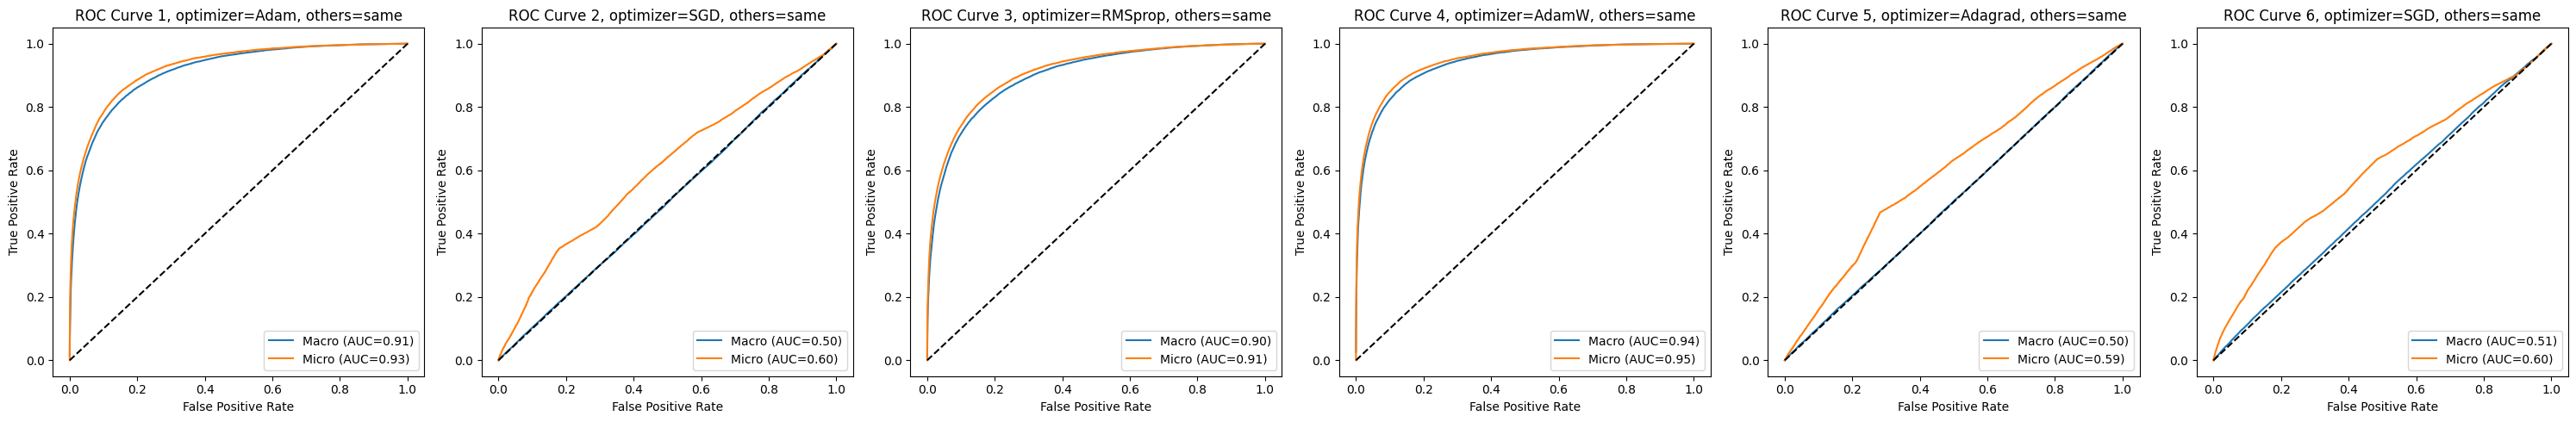

In [147]:
plot_rocauc(exp1_results, ["optimizer", "others"], curve_type="macro_micro", n_rows=1, n_cols=6)

## 3.2 Experiment 2: Epoch Number and Learning Rate
This experiment seeks to find the effect of different combinations of epoch numbers and learning rates on the training & testing performance of the neural network.

### 3.2.1 Experiment 2-1: Rough Search
In this sub-experiment, we perform a rough search on the epochs and learning rate. We promoted four possible values for both parameters:
$$
\text{candidate epochs}=\{10, 15, 20, 25\}
$$
$$
\text{candidate lr}=\{1.0\times 10^{-3},1.0\times 10^{-4},1.0\times 10^{-5},1.0\times 10^{-6}\}
$$

In [ ]:
# Universal Train Dataset without splitting
exp2_universal_train_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"train_32x32.mat"))
exp2_mean, exp2_std = exp2_universal_train_dataset.get_meanstd()

print(f"Channel Means: {exp2_mean}")
print(f"Channel Stds: {exp2_std}")

In [ ]:
exp2_hyperparams = {
    "criterion": nn.CrossEntropyLoss(),
    "transform": A.Compose([
        A.Normalize(mean=exp2_mean, std=exp2_std),
        ToTensorV2()
    ]),
    "optimizer":optim.Adam,
}

candidate_epochs = [10, 15, 20, 25]
candidate_lr = [1e-3, 1e-4, 1e-5, 1e-6]

In [ ]:
torch.cuda.empty_cache()

# Train & Validation Datasets
exp2_train_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"train_32x32.mat"), transform=exp2_hyperparams['transform'])
exp2_train_dataset, exp2_valid_dataset = split_train_valid(exp2_train_dataset, train_ratio=0.8)

# Test Dataset
exp2_test_dataset = SVHNDataset(mat_file=os.path.join(path_dataset,"test_32x32.mat"), transform=exp2_hyperparams['transform'])

print(f"Train Size:{exp2_train_dataset.__len__()}\nValidation Size:{exp2_valid_dataset.__len__()}\nTest Size:{exp2_test_dataset.__len__()}")

In [ ]:
exp2_train_loader = DataLoader(exp2_train_dataset, batch_size=128, shuffle=True)
exp2_valid_loader = DataLoader(exp2_valid_dataset, batch_size=128, shuffle=True)
exp2_test_loader = DataLoader(exp2_valid_dataset, batch_size=128, shuffle=False)

In [ ]:
def run_exp2(epochs, lr_list, hyper_params, train_loader, test_loader):
    combinations = list(itertools.product(epochs, lr_list))
    experiments = []
    for i, combo in enumerate(combinations):
        num_epochs, lr = combo

        print(f"Running Exp {i+1}: num_epoch={num_epochs}, lr={lr}")
        this_model = SmallVGG().to(device)
        criterion = hyper_params['criterion']
        optimizer = hyper_params['optimizer'](this_model.parameters(), lr=lr)
        train_losses, valid_losses = train_and_evaluate(this_model, train_loader, test_loader, criterion, optimizer, num_epochs)

        experiments.append({
            "num_epochs": num_epochs,
            "lr": lr,
            "train_losses": train_losses,
            "valid_losses": valid_losses,
            "model_state_dict": this_model.state_dict()
        })

        del this_model, criterion, optimizer
    return experiments

In [ ]:
exp2 = run_exp2(candidate_epochs, candidate_lr, exp2_hyperparams, exp2_train_loader, exp2_valid_loader)
time_str = str(time.time()).replace(".","")
torch.save(exp2, f"./models/exp2_1_{time_str}.pth")

In [ ]:
exp2_loaded = torch.load("./models/exp2_1_1730229238268616.pth")
exp2_results = get_experiment_results(exp2_loaded, test_hyperparam_names=["num_epochs", "lr"], extra_loader=exp2_test_loader)

#### 3.2.1-1 Epoch-Loss Curve
We found that the key to the training performance of a model is the learning rate. Epoch number only controls the progress of training.

From the perspective of learning rate (each column), only the learning rate of $1.0\times 10^{-3}$ shows a sign of convergence under each candidate epochs. With this learning rate, the model even overfitted under experiments with an epoch number over $15$. 
The best model we conclude from this rough selection is the one with the combination of $\text{num\_epoch}=10\land\text{lr}=1.0\times10^{-3}$. The minimum validation loss is $36.648$ at step $7$, which is the lowest of all $16$ samples. However, this doesn't mean that it is optimal since it may jump over a local minimum. 

Moreover, as we inspect the performance on smaller learning rates, we found that they tend to converge in a way further epoch steps. Moreover, for the learning rate $1.0\times 10^{-6}$, the learning rate is too low that the model can not even fit under nearly-finite epochs.

In [ ]:
plot_el(exp2_loaded, ["num_epochs", "lr"], n_rows=4, n_cols=4)

#### 3.2.1-2 Confusion Matrix
In this rough search, the confusion matrix varies on different learning rates, and tends to be identical on different epochs.

Under a same epoch number, as leraning rate gets smaller, the confusion matrix gets "blurrer", meaning that the prediction is less accurate from the whole perspective. The learning rates under $1.0\times 10^{-4}$ are too low that the model can't converge in a reasonably number of epochs. For the lowest learning rate of $1.0\times 10^{-6}$, the model is not fitted at all. It classifies every number into 1, the number with the richest amount in the dataset.

In [ ]:
plot_cm(exp2_results, ["num_epochs", "lr"], n_rows=4, n_cols=4)

#### 3.2.1-3 Precision-Recall Curve
From a numerical perspective over the testing performance, the combination of $\text{num\_epoch}=10\land\text{lr}=1.0\times10^{-3}$ gives the highest accuracy of $0.920$, highest average $F_1$ score of $0.916$ and the lowest $F_1$ variance per-class of $0.019$.

In [ ]:
exp2_accuracies, exp2_f1s = plot_pr(exp2_results, ["num_epochs", "lr"], n_rows=4, n_cols=4)
print(f"Accuracies:")
for acc in exp2_accuracies:
    print(f"{acc:.3f}", end=", ")
print("\n")

print(f"F1 Score Lists:")
for f1 in exp2_f1s:
    for val in f1:
        print(f"{val:.3f}", end=", ")
    print(f"Avg F1={np.mean(f1):.3f}, Std={np.std(f1):.3f}")

In [ ]:
plot_rocauc(exp2_results, ["num_epochs", "lr"], curve_type="all", n_rows=4, n_cols=4)

In [ ]:
plot_rocauc(exp2_results, ["num_epochs", "lr"], curve_type="macro_micro", n_rows=4, n_cols=4)

### 3.2.2 Experiment 2-2: Detailed
Previous sub-experiment tells that the best combination from all the listed ones is $\text{num\_epoch}=10 \land \text{lr}=1.0\times 10^{-3}$.

This is a rough solution, as it may jump over local minimums. We want to find a better learning rate around $1.0\times 10^{-3}$, with an even more detailed distinction between candidate values, so that it may reveal a missing local minimum without using too much epochs.

We conducted an excessive experiment, purposely seeking an overfitting point over the listed candidate learning rates. We do this by setting the epoch number to $50$.

In [ ]:
exp2_2_hyperparams = {
    "num_epoch": 50,
    "criterion": nn.CrossEntropyLoss(),
    "transform": A.Compose([
        A.Normalize(mean=exp2_mean, std=exp2_std),
        ToTensorV2()
    ]),
    "optimizer":optim.Adam,
}

# More detailed candidate learning rates around 1e-4, that is 10e-4.
exp2_2_candidate_lr = [17e-4, 15e-4, 15e-4, 14e-4, 13e-4, 12e-4, 8e-4, 7e-4, 6e-4, 5e-4, 4e-4, 3e-4]

In [ ]:
def run_exp2_2(lr_list, hyper_params, train_loader, test_loader):
    experiments = []
    for i, lr in enumerate(lr_list):

        print(f"Running Exp {i+1}: lr={lr}")
        this_model = SmallVGG().to(device)
        num_epochs = hyper_params['num_epoch']
        criterion = hyper_params['criterion']
        optimizer = hyper_params['optimizer'](this_model.parameters(), lr=lr)
        train_losses, valid_losses = train_and_evaluate(this_model, train_loader, test_loader, criterion, optimizer, num_epochs)

        experiments.append({
            "num_epochs": num_epochs,
            "lr": lr,
            "train_losses": train_losses,
            "valid_losses": valid_losses,
            "model_state_dict": this_model.state_dict()
        })

        del this_model, criterion, optimizer
    return experiments

In [ ]:
exp2_2 = run_exp2_2(exp2_2_candidate_lr, exp2_2_hyperparams, exp2_train_loader, exp2_valid_loader)
time_str = str(time.time()).replace(".", "")
torch.save(exp2_2, f"./models/exp2_2_{time_str}.pth")

In [ ]:
exp2_2_loaded = torch.load("./models/exp2_2_17302741969577262.pth")
exp2_2_results = get_experiment_results(exp2_2_loaded, test_hyperparam_names=["num_epochs", "lr"], extra_loader=exp2_test_loader)

#### 3.2.2-1 Epoch-Loss Curve
By inspecting the epoch-loss curve, we found that all the experiments are overfitted. This means that $50$ epochs are enough for conducting the detailed search. 

From all the detailed searches, the learning rate of $14\times10^{-4}$, that is `1.4e-3`, yields the lowest validation loss of $36.259$ at step $5$, which is the overfitting point. We discovered a new local minimum that's been jumped over by learning rate of `1e-3`, which previously yield a validation loss of $36.648$.

In [ ]:
plot_el(exp2_2_loaded, ["num_epochs", "lr"], n_rows=2, n_cols=6)

#### 3.2.2-2 Confusion Matrix
At a glance, from the perspective of confusion matrix, the testing performance on unknown data is roughly identical.

In [ ]:
plot_cm(exp2_2_results, ["num_epochs", "lr"], n_rows=2, n_cols=6)

#### 3.2.2-3 Precision-Recall Curve
By inspecting the evaluation metrics, we found our judgement correct. From all the over-fitted model, the model with learning rate of $7.0\times 10^{-4}$ yields the highest accuracy of $0.909$ and the highest average per-class $F_1$ score of $0.903$. Besides, the per-class $F_1$ score is also less variant under the learning rate of $7.0\times 10^{-4}$, with the standard deviation of $0.023$.

In [ ]:
exp2_2_accuracies, exp2_2_f1s = plot_pr(exp2_2_results, ["num_epochs", "lr"], n_rows=2, n_cols=6)
print(f"Accuracies:")
for acc in exp2_2_accuracies:
    print(f"{acc:.3f}", end=", ")
print("\n")

print(f"F1 Score Lists:")
for f1 in exp2_2_f1s:
    for val in f1:
        print(f"{val:.3f}", end=", ")
    print(f"Avg F1={np.mean(f1):.3f}, Std={np.std(f1):.3f}")

#### 3.2.2-4 ROC-AUC Curve
The ROC-AUC Curve under all the detailed candidate learning rates are roughly identical.

In [ ]:
plot_rocauc(exp2_2_results, ["num_epochs", "lr"], curve_type="all", n_rows=2, n_cols=6)

In [ ]:
plot_rocauc(exp2_2_results, ["num_epochs", "lr"], curve_type="macro_micro", n_rows=2, n_cols=6)

## 3.3 Experiment 3: Image Augmentation Parameters

### 3.3.1 Experiment 3-1: Rotation Angles and Crop Ratios

In [ ]:
exp3_universal_train_dataset = SVHNDataset(mat_file=os.path.join(path_dataset, "train_32x32.mat"))

# The mean & std here will only be used for experiment 3-1.
exp3_1_mean, exp3_1_std = exp3_universal_train_dataset.get_meanstd()

print(f"Channel Means: {exp3_1_mean}\nChannel Stds: {exp3_1_std}")

In [ ]:
exp3_1_hyperparams = {
    "num_epochs": 10,
    "lr": 1e-3,
    "criterion": nn.CrossEntropyLoss(),
    "optimizer": optim.Adam,
    "transform": A.Compose([
        A.Normalize(mean=exp1_mean, std=exp1_std),
        ToTensorV2()
    ])
}

# Group 1
candidate_angles = [15, 30, 45, 60]
candidate_crops = [0.08, 0.24, 0.40, 0.60] # Left Boundary

In [ ]:
torch.cuda.empty_cache()

# Train & Validation Datasets
exp3_train_dataset = SVHNDataset(mat_file=os.path.join(path_dataset, "train_32x32.mat"))
exp3_train_dataset, exp3_valid_dataset = split_train_valid(exp3_train_dataset, train_ratio=0.8)

# Test Dataset
exp3_test_dataset = SVHNDataset(mat_file=os.path.join(path_dataset, "test_32x32.mat"))
print(f"Train Size:{exp3_train_dataset.__len__()}\nValidation Size:{exp3_valid_dataset.__len__()}\nTest Size:{exp3_test_dataset.__len__()}")

In [ ]:
def run_exp3_1(angles, crops, hyper_params, train_dataset, valid_dataset):
    combinations = list(itertools.product(angles, crops))
    experiments = []
    for i, combo in enumerate(combinations):
        angle, crop = combo
        
        print(f"Running Exp {i+1}: angles={angle}, crop={crop}")
        this_model = SmallVGG().to(device)
        num_epochs = hyper_params['num_epochs']
        lr = hyper_params['lr']
        criterion = hyper_params['criterion']
        optimizer = hyper_params['optimizer'](this_model.parameters(), lr=lr)

        # Define Transform
        this_transform = A.Compose([
            A.RandomResizedCrop(32, 32, scale=(crop, 1.0)),
            A.Rotate(limit=angle),
            A.Normalize(mean=exp3_1_mean, std=exp3_1_std),
            ToTensorV2()
        ])

        # Generate Dataset
        print(f"Exp {i+1}: Generating dataset from transform")
        train_dataset.transform = this_transform
        valid_dataset.transform = this_transform
        
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

        # Train Model
        train_losses, valid_losses = train_and_evaluate(this_model, 
                                                       train_loader, 
                                                       valid_loader, 
                                                       criterion, 
                                                       optimizer,
                                                       num_epochs)

        experiments.append({
            "angle": angle,
            "crop": crop,
            "train_losses": train_losses,
            "valid_losses": valid_losses,
            "model_state_dict": this_model.state_dict()
        })

        del this_model, criterion, optimizer
        del train_loader, valid_loader
        
        train_dataset.transform = None
        valid_dataset.transform = None
        torch.cuda.empty_cache()

    return experiments

In [ ]:
exp3_1 = run_exp3_1(candidate_angles, candidate_crops, exp3_1_hyperparams, exp3_train_dataset, exp3_valid_dataset)
time_str = str(time.time()).replace(".","")
torch.save(exp3_1, f"./models/exp3_1_{time_str}.pth")

In [ ]:
exp3_1_loaded = torch.load("./models/exp3_1_17302968580804682.pth")
exp3_1_results = get_experiment_results(exp3_1_loaded, test_hyperparam_names=["angle", "crop"], extra_loader=exp3_test_loader)

In [ ]:
plot_el(exp3_1_loaded, ["angle", "crop"], n_rows=4, n_cols=4)

In [ ]:
plot_cm(exp3_1_results, ["angle", "crop"], n_rows=4, n_cols=4)

In [ ]:
exp3_accuracies, exp3_f1s = plot_pr(exp3_1_results, ["angle", "crop"], n_rows=4, n_cols=4)
print(f"Accuracies:")
for acc in exp3_accuracies:
    print(f"{acc:.3f}", end=", ")
print("\n")

print(f"F1 Score Lists:")
avg_f1s = []
for f1 in exp3_f1s:
    for val in f1:
        print(f"{val:.3f}", end=", ")
    avg_f1s.append(np.mean(f1))
    print(f"Avg F1={np.mean(f1):.3f} Std F_1={np.std(f1):.3f}")
print(f"Best: {np.argmax(avg_f1s)+1}-th")

In [ ]:
plot_rocauc(exp3_1_results, ["angle", "crop"], curve_type="all", n_rows=4, n_cols=4)

In [ ]:
plot_rocauc(exp3_1_results, ["angle", "crop"], curve_type="macro_micro", n_rows=4, n_cols=4)

### 3.3.2 Experiment 3-2: Ratios & Bias

In [ ]:
exp3_2_hyperparams = {
    "num_epoch": 15,
    "lr": 1e-3,
    "criterion": nn.CrossEntropyLoss(),
    "optimizer": optim.Adam,
    "crop": 0.08,
    "angle": 45
}

# Group 2
candidate_ratios = [0.25, 0.42, 0.58, 0.75]
candidate_channel_biases = [0, 32, 64, 128]

Control candidates for different variables

### 3.2.1 Design Hyper Parameger
Set the candidate hyper parameters.

In [ ]:
candidate_epoch_num = [20, 40, 60, 80]
candidate_lr = [1e-3, 1e-4, 1e-5, 1e-6]

From the controlled variables, generate all the possible experiment set.

In [ ]:
combinations = list(itertools.product(candidate_epoch_num, candidate_lr))
for combo in combinations:
    print(f"[{combo[0]}, {combo[1]:.0e}]", end=" ")

### 3.2.2 Train Models
Train the models for all the generated hyper-parameter combinations.

In [ ]:
def run_experiment(candidate_epoch_num, candidate_lr):
    combinations = list(itertools.product(candidate_epoch_num, candidate_lr))
    experiments = [] # Experiment Instances
    
    for combo in combinations:
        print(f"Performing Experiment: epoch_num={combo[0]}, lr={combo[1]}")
        exp_model = SmallVGG().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(exp_model.parameters(), lr=combo[1])
        num_epochs = combo[0]
    
        train_losses, valid_losses = train_and_evaluate(exp_model, train_loader, test_loader, criterion, optimizer, num_epochs)

        # One experiment instance
        experiments.append({
            "num_epoch": combo[0],
            "lr": combo[1],
            "train_losses": train_losses,
            "valid_losses": valid_losses,
            "model_state_dict": exp_model.state_dict()
        })
        
        # Prevent CUDA Mem Leak
        del exp_model, criterion, optimizer
        torch.cuda.empty_cache()
        
    return experiments

In [ ]:
experiments = run_experiment(candidate_epoch_num, candidate_lr)
time_str = str(time.time()).replace(".","")
torch.save(experiments, f"./models/experiments_{time_str}.pth")

### 3.2.3 Load Experiments
Load the saved experiments, and plot the epoch-loss curve to inspect training performance.

In [ ]:
loaded_experiments = torch.load("./models/experiments_17296227919579012.pth")

In [ ]:
plot_el(loaded_experiments)

### 3.2.4 Apply Model, Get Result

In [ ]:
def get_experiment_results(loaded_experiments, extra_loader):
    experiment_results = []
    for i, exp in enumerate(loaded_experiments):
        pred_scores, true_labels_cpu, pred_labels_cpu = get_predictions(exp["model_state_dict"], extra_loader)
        print(f"Experiment {i+1}, num_epoch={exp['num_epoch']}, lr={exp['lr']}")
        print("First 100 true labels:")
        [print(num, end=" ") for num in true_labels_cpu[:100]]
        print("...\n")
    
        print("First 100 true predictions:")
        [print(num, end=" ") for num in pred_labels_cpu[:100]]
        print("...\n")
    
        print("First 5 prediction Probabilities:")
        [print(num, end=" ") for num in pred_scores[:5]]
        print("...")
    
        experiment_results.append({
            "epoch_num": exp['num_epoch'],
            "lr": exp['lr'],
            "true_labels": true_labels_cpu,
            "pred_labels": pred_labels_cpu,
            "pred_scores": pred_scores
        })
    
        del pred_scores, true_labels_cpu, pred_labels_cpu
        torch.cuda.empty_cache()
    return experiment_results

In [ ]:
experiment_results = get_experiment_results(loaded_experiments, extra_loader)

### 3.2.5 Confusion Matrix

In [ ]:
plot_cm(experiment_results, ['epoch_num', 'lr'])

### 3.2.6 Precision-Recall Curve

In [ ]:
plot_pr(experiment_results, ['epoch_num', 'lr'])

### 3.2.7 ROC AUC Curve

In [ ]:
plot_roc_auc(experiment_results, ['epoch_num','lr'], "macro_micro")

In [ ]:
plot_roc_auc(experiment_results, ['epoch_num','lr'], "all")